In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import beta
import plotly.express as px

import warnings
# Filter out all warnings
warnings.filterwarnings('ignore', category=Warning)

In [6]:
#Ingest Conversion Log Data
conv_log = pd.read_csv('publisher_brand_conv.csv')
#change all columns to lowercase
conv_log.columns = conv_log.columns.str.lower()
#Convert order_date to date type
conv_log['order_date'] = pd.to_datetime(conv_log['order_date'])
conv_log.sample(5)

,order_date,widget_type,target,publisher_name,brand_name,conv,total_ad_spend
10225,2024-03-25,DISCOFEED,non-target,Laura Geller,Vegamour,1,0.0
9463,2024-03-09,DISCOFEED,non-target,Tushbaby,Tubby Todd Bath Co.,5,10.0
10693,2024-03-23,LEAD_GEN,non-target,INTO THE AM,cbdMD,1,20.0
2230,2024-03-19,DISCOFEED,non-target,Bear Mattress,Caraway,1,70.0
2140,2024-03-30,DISCOFEED,non-target,Primally Pure,Canopy,1,0.0


In [11]:
conv_details = pd.read_csv('order_details.csv')
#change all columns to lowercase
conv_details.columns = conv_details.columns.str.lower()
#Convert event_date to date type
conv_details['event_date'] = pd.to_datetime(conv_details['event_date'])
#Convert order_created_at to datetime 
conv_details['order_created_at'] = pd.to_datetime(conv_details['order_created_at'])
conv_details.sample(5)

,order_created_at,event_date,order_id,publisher_name,event_classification,widget_type,days_to_attribution,customer_type,billable_amount,discount_codes,order_cost,order_event_ip_address,order_event_user_agent,shipping_address_zip_code,line_items,order_tags,order_source_name,landing_site
86,2024-03-25 23:24:48+00:00,2024-03-18,5256464367676,Tubby Todd Bath Co.,display,DISCOFEED,7,returning,10.0,SAVE20,132.97,98.121.5.236,Mozilla/5.0 (iPad; CPU OS 17_4 like Mac OS X) ...,37208,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/collections/matching-family-swimsuits?nbt=nb:...
122,2024-03-22 17:35:39+00:00,2024-03-16,5251993960508,Twillory,display,LEAD_GEN,6,new,20.0,HELLOF7466ZVB,123.62,47.223.120.51,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3_1 like...,75693,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/products/long-sleeve-rash-guard-with-ruffle-b...
309,2024-03-24 01:04:55+00:00,2024-03-21,5253933432892,Twillory,display,LEAD_GEN,3,lapsed,20.0,SAVE15,60.53,76.124.69.178,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3_1 like...,19403,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/
306,2024-03-23 17:07:55+00:00,2024-03-18,5253390958652,Twillory,display,LEAD_GEN,5,new,20.0,NaN,104.40,174.211.104.168,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3_1 like...,33478,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/products/gone-fishing-two-piece-pajama-set?va...
439,2024-03-24 16:17:09+00:00,2024-03-23,5254741622844,Twillory,display,LEAD_GEN,1,new,20.0,NaN,81.22,76.219.232.149,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,92694,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/?ranEAID=dquE8U2QoAw&ranMID=48141&ranSiteID=d...


## Exploration

#### Conversion Volume

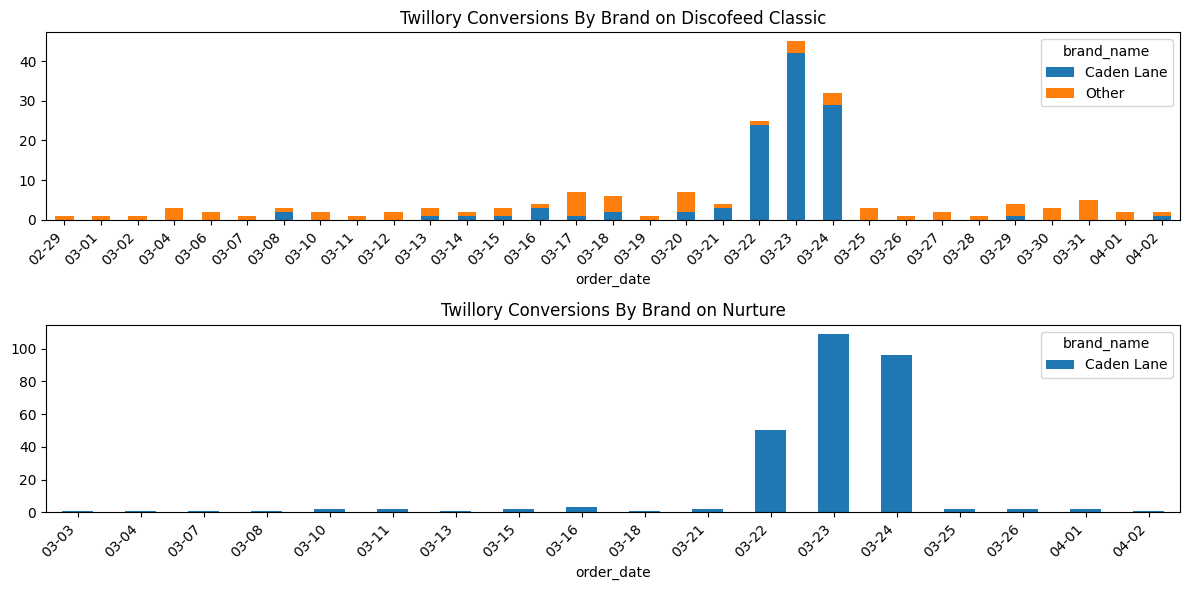

In [31]:
# Filter conv_log where publisher_name = 'Twillory'
twillory = conv_log[conv_log['publisher_name'] == 'Twillory']
# If brand_name is not 'Caden Lane' then set it to 'other'
twillory['brand_name'] = np.where(twillory['brand_name'] != 'Caden Lane', 'Other', twillory['brand_name'])
# Set order_date as an object
twillory['order_date'] = twillory['order_date'].dt.strftime('%m-%d')

# Create subsets based on widget_type
twillory_discofeed = twillory[twillory['widget_type'] == 'DISCOFEED']
twillory_lead_gen = twillory[twillory['widget_type'] == 'LEAD_GEN']

# Define a function to create the stacked bar chart
def create_stacked_bar_chart(df, ax, title):
    # Group by 'order_date' and 'brand_name', then sum the 'conv' values
    data = df.groupby(['order_date', 'brand_name'])['conv'].sum().unstack().fillna(0)
    # Create the bar chart
    data.plot(kind='bar', stacked=True, ax=ax)
    # Set the title of the plot
    ax.set_title(title)
    # Rotate x-axis labels if there are many dates
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Create a figure with two subplots, one on top of the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the two visualizations
create_stacked_bar_chart(twillory_discofeed, ax1, 'Twillory Conversions By Brand on Discofeed Classic')
create_stacked_bar_chart(twillory_lead_gen, ax2, 'Twillory Conversions By Brand on Nurture')

# Adjust the layout
plt.tight_layout()
plt.show()

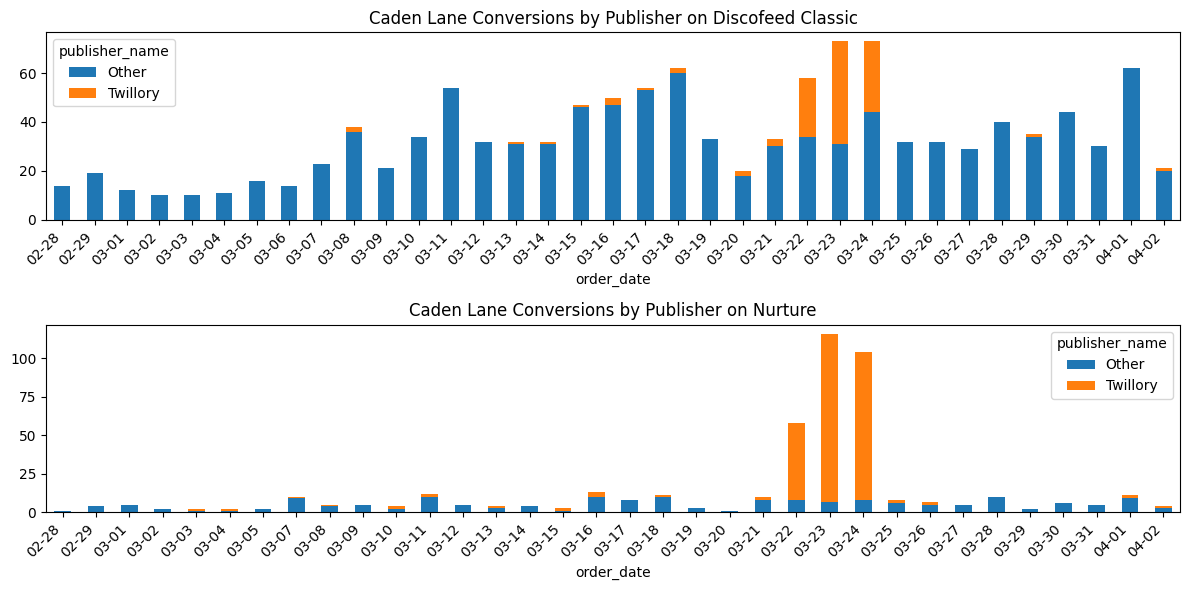

In [32]:
# Step 1: Filter out for brand_name = 'Caden Lane'
caden_lane = conv_log[conv_log['brand_name'] == 'Caden Lane']

# Step 2: For the filtered DataFrame, replace non 'Twillory' publisher names with 'Other'
caden_lane['publisher_name'] = np.where(caden_lane['publisher_name'] == 'Twillory', 'Twillory', 'Other')

# Step 3: Format 'order_date' as MM-DD string
caden_lane['order_date'] = caden_lane['order_date'].dt.strftime('%m-%d')

# Create subsets based on widget_type
caden_lane_discofeed = caden_lane[caden_lane['widget_type'] == 'DISCOFEED']
caden_lane_lead_gen = caden_lane[caden_lane['widget_type'] == 'LEAD_GEN']

# Define a function to create the stacked bar chart
def create_stacked_bar_chart(df, ax, title):
    # Group by 'order_date' and 'publisher_name', then sum the 'conv' values
    data = df.groupby(['order_date', 'publisher_name'])['conv'].sum().unstack().fillna(0)
    # Create the bar chart
    data.plot(kind='bar', stacked=True, ax=ax)
    # Set the title of the plot
    ax.set_title(title)
    # Rotate x-axis labels if there are many dates
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Create a figure with two subplots, one on top of the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the two visualizations
create_stacked_bar_chart(caden_lane_discofeed, ax1, 'Caden Lane Conversions by Publisher on Discofeed Classic')
create_stacked_bar_chart(caden_lane_lead_gen, ax2, 'Caden Lane Conversions by Publisher on Nurture')

# Adjust the layout
plt.tight_layout()
plt.show()

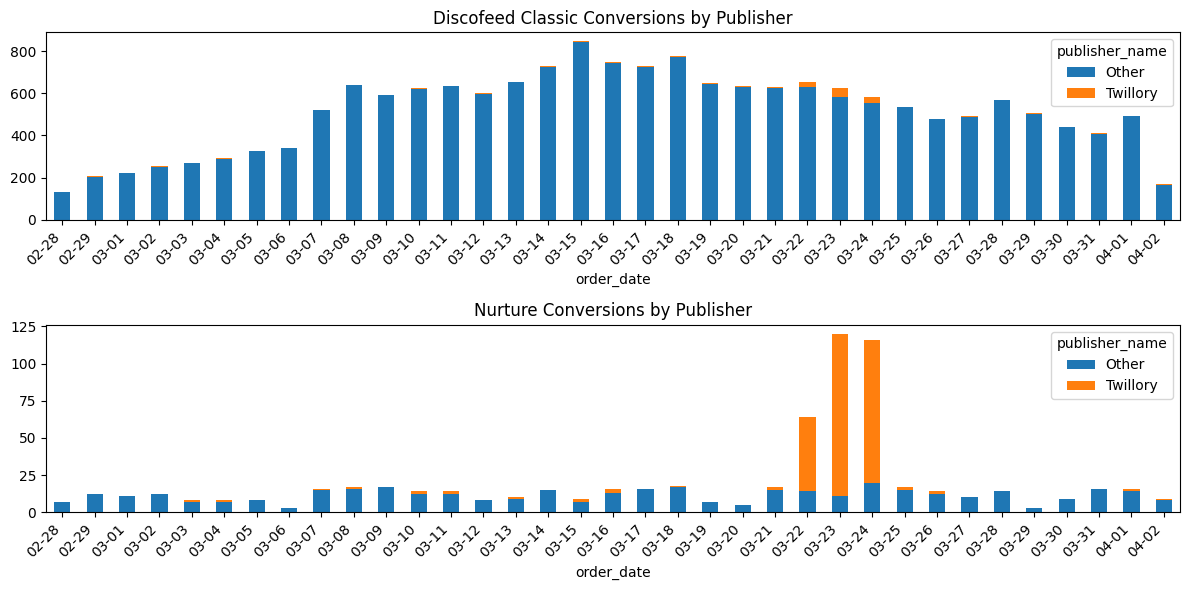

In [35]:
#Look at conversions by publisher
publisher = conv_log.copy()

# Step 2: For the filtered DataFrame, replace non 'Twillory' publisher names with 'Other'
publisher['publisher_name'] = np.where(publisher['publisher_name'] == 'Twillory', 'Twillory', 'Other')

# Step 3: Format 'order_date' as MM-DD string
publisher['order_date'] = publisher['order_date'].dt.strftime('%m-%d')

# Create subsets based on widget_type
publisher_discofeed = publisher[publisher['widget_type'] == 'DISCOFEED']
publisher_lead_gen = publisher[publisher['widget_type'] == 'LEAD_GEN']

# Define a function to create the stacked bar chart
def create_stacked_bar_chart(df, ax, title):
    # Group by 'order_date' and 'publisher_name', then sum the 'conv' values
    data = df.groupby(['order_date', 'publisher_name'])['conv'].sum().unstack().fillna(0)
    # Create the bar chart
    data.plot(kind='bar', stacked=True, ax=ax)
    # Set the title of the plot
    ax.set_title(title)
    # Rotate x-axis labels if there are many dates
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Create a figure with two subplots, one on top of the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the two visualizations
create_stacked_bar_chart(publisher_discofeed, ax1, 'Discofeed Classic Conversions by Publisher')
create_stacked_bar_chart(publisher_lead_gen, ax2, 'Nurture Conversions by Publisher')

# Adjust the layout
plt.tight_layout()
plt.show()

The conversion spike seems to be a Twillory / Caden Lane specific issue, that is not exclusive just to Nurture. 
- Caden Lane, as a brand, has relatively stable conversion counts on all publishers except Twillory
- Vice versa for Twillory, as a publisher 
- Spikes happen on both Discofeed and Nurture

However, this effect is outsized on Nurture due to its smaller conversion volumes. 

#### Conversion Details

In [42]:
conv_df = conv_details.copy()
#if publisher_name is not 'Twillory' then set it to 'Other'
conv_df['publisher_name'] = np.where(conv_df['publisher_name'] != 'Twillory', 'Other', conv_df['publisher_name'])
conv_df.sample(5)

,order_created_at,event_date,order_id,publisher_name,event_classification,widget_type,days_to_attribution,customer_type,billable_amount,discount_codes,order_cost,order_event_ip_address,order_event_user_agent,shipping_address_zip_code,line_items,order_tags,order_source_name,landing_site
285,2024-03-23 21:50:15+00:00,2024-03-20,5253758812220,Twillory,display,LEAD_GEN,3,new,20.0,SAVE15,76.41,24.113.22.150,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3 like M...,98367,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/?nbt=nb:adwords:g:14249390527:126551892700:62...
302,2024-03-23 17:37:55+00:00,2024-03-18,5253433819196,Twillory,display,LEAD_GEN,5,new,20.0,NaN,72.61,75.174.214.214,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3_1 like...,83686,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/collections/newborn-outfits-2
39,2024-03-25 08:27:10+00:00,2024-03-23,5255741210684,Other,display,LEAD_GEN,2,new,20.0,YOUNEEDTHIS15,57.40,47.157.180.64,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3 like M...,93036,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/collections/personalized-swaddles-blankets-1?...
194,2024-03-24 14:30:01+00:00,2024-03-23,5254610681916,Twillory,display,LEAD_GEN,1,returning,10.0,SAVE15,84.70,73.141.159.186,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,19335,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/?nbt=nb:microsoft:o:435892252:133590821355955...
499,2024-03-24 00:27:14+00:00,2024-03-20,5253901254716,Twillory,display,LEAD_GEN,4,new,20.0,SAVE15,132.46,73.152.168.141,Mozilla/5.0 (iPhone; CPU iPhone OS 17_3_1 like...,22556,"[\n {\n ""discount_amount"": ""0.00"",\n ""p...",NaN,web,/collections/personalized-knit-sweater-sets?ut...


In [37]:
def plot_column_analysis(df, column_name, analysis_type):
    # Validate input arguments
    if analysis_type not in ['volume', 'percent']:
        raise ValueError("analysis_type must be 'volume' or 'percent'")
    if column_name not in df.columns:
        raise ValueError(f"{column_name} does not exist in the DataFrame")

    # Define the plotting function
    def plot_chart(data, title, ax, analysis_type):
        if analysis_type == 'volume':
            data.value_counts().plot(kind='bar', ax=ax)
        elif analysis_type == 'percent':
            (data.value_counts(normalize=True) * 100).plot(kind='bar', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel(column_name)
        ax.set_ylabel('Volume' if analysis_type == 'volume' else 'Percent')
        plt.xticks(rotation=45, ha='right')

    # Create a figure with two subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot the barcharts for Twillory and Other
    twillory_data = df[df['publisher_name'] == 'Twillory'][column_name]
    other_data = df[df['publisher_name'] == 'Other'][column_name]
    
    plot_chart(twillory_data, f"Twillory - {analysis_type.title()}", ax1, analysis_type)
    plot_chart(other_data, f"Other - {analysis_type.title()}", ax2, analysis_type)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

In [51]:
def plot_column_analysis2(df, column_name, analysis_type):
    # Validate input arguments
    if analysis_type not in ['volume', 'percent']:
        raise ValueError("analysis_type must be 'volume' or 'percent'")
    if column_name not in df.columns:
        raise ValueError(f"{column_name} does not exist in the DataFrame")
    
    # Group and count or normalize the data based on the analysis_type
    grouped = df.groupby(['publisher_name', column_name, 'widget_type']).size().reset_index(name='count')
    if analysis_type == 'percent':
        # Calculate the percentage
        total_counts = grouped.groupby(['publisher_name', column_name])['count'].transform('sum')
        grouped['count'] = (grouped['count'] / total_counts) * 100
    
    # Pivot the data to get counts or percentages for each widget_type stacked by column_name
    pivoted = grouped.pivot_table(index=[column_name, 'publisher_name'], 
                                  columns='widget_type', 
                                  values='count', 
                                  fill_value=0).reset_index()

    # Separate the data for Twillory and Other
    twillory_data = pivoted[pivoted['publisher_name'] == 'Twillory']
    other_data = pivoted[pivoted['publisher_name'] == 'Other']
    
    # Create a figure with two subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot the bar charts
    twillory_data.set_index(column_name).plot(kind='bar', stacked=True, ax=ax1, title='Twillory')
    other_data.set_index(column_name).plot(kind='bar', stacked=True, ax=ax2, title='Other')

    # Set labels and titles
    ax1.set_ylabel('Volume' if analysis_type == 'volume' else 'Percent')
    ax2.set_ylabel('Volume' if analysis_type == 'volume' else 'Percent')
    ax2.set_xlabel(column_name)
    ax1.legend(title='Widget Type')
    ax2.legend(title='Widget Type')

    # Rotate x-axis labels for better readability
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

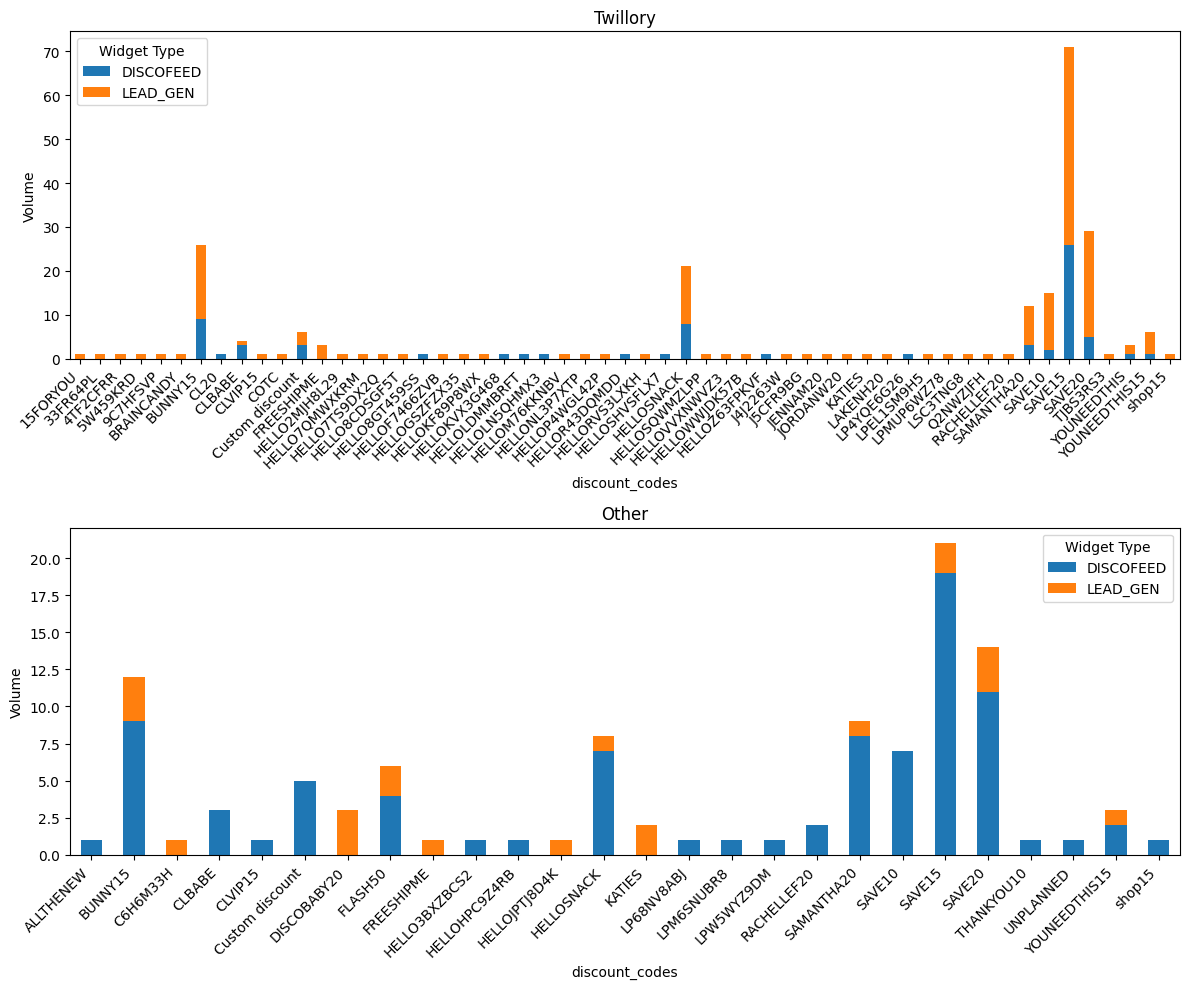

In [52]:
plot_column_analysis2(conv_df, 'discount_codes', 'volume')

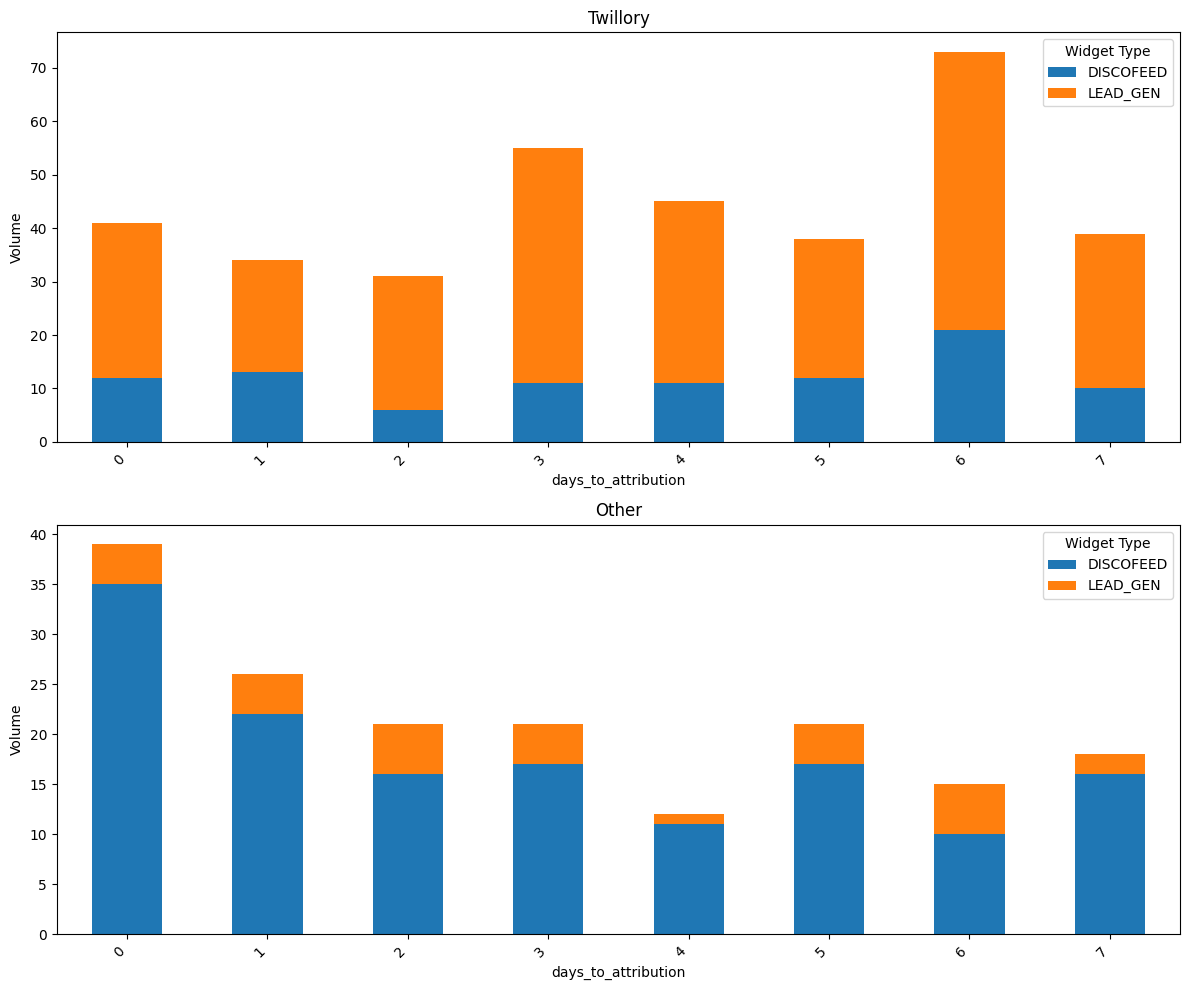

In [55]:
plot_column_analysis(conv_df,'days_to_attribution','volume')

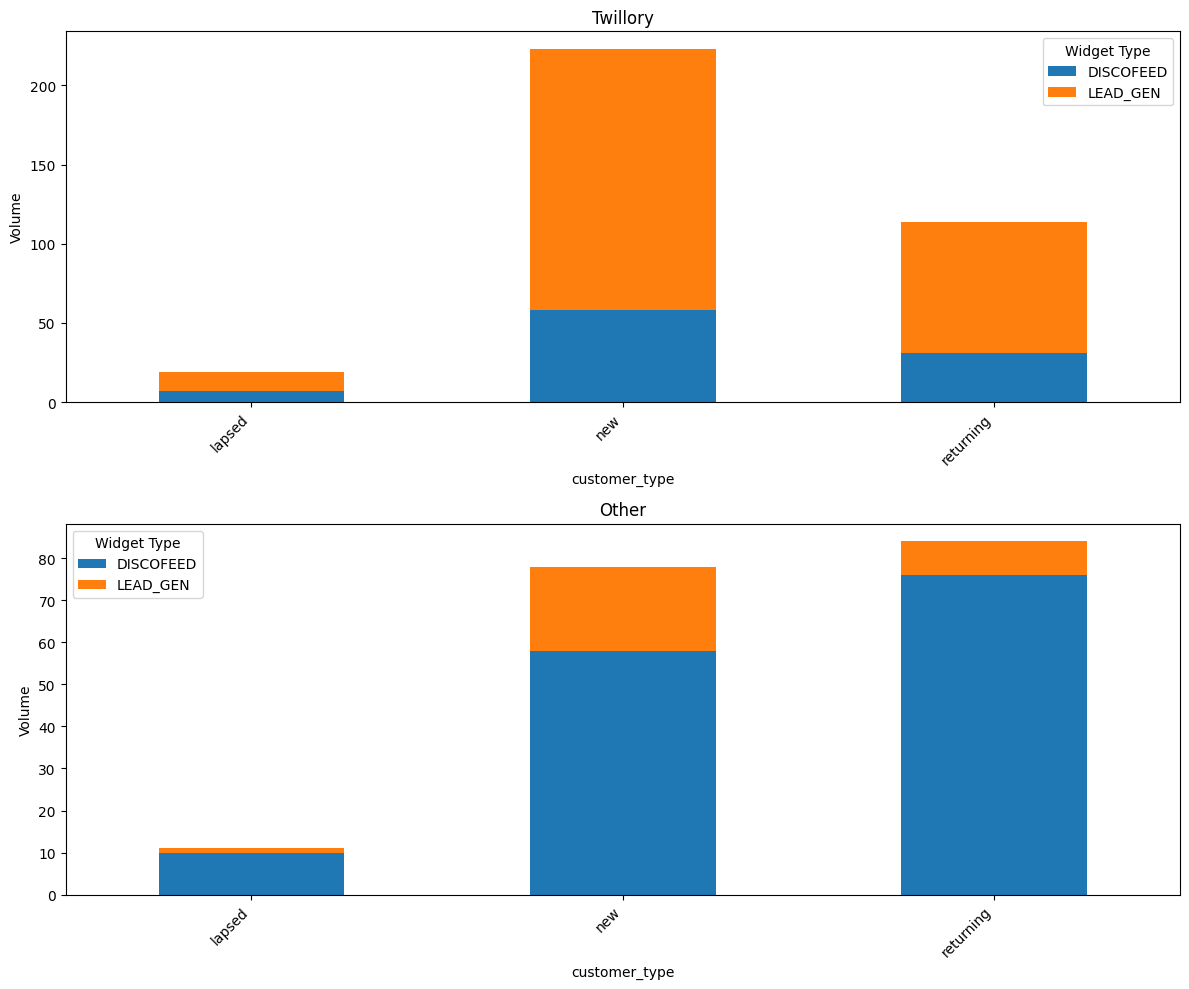

In [53]:
plot_column_analysis2(conv_df,'customer_type','volume')

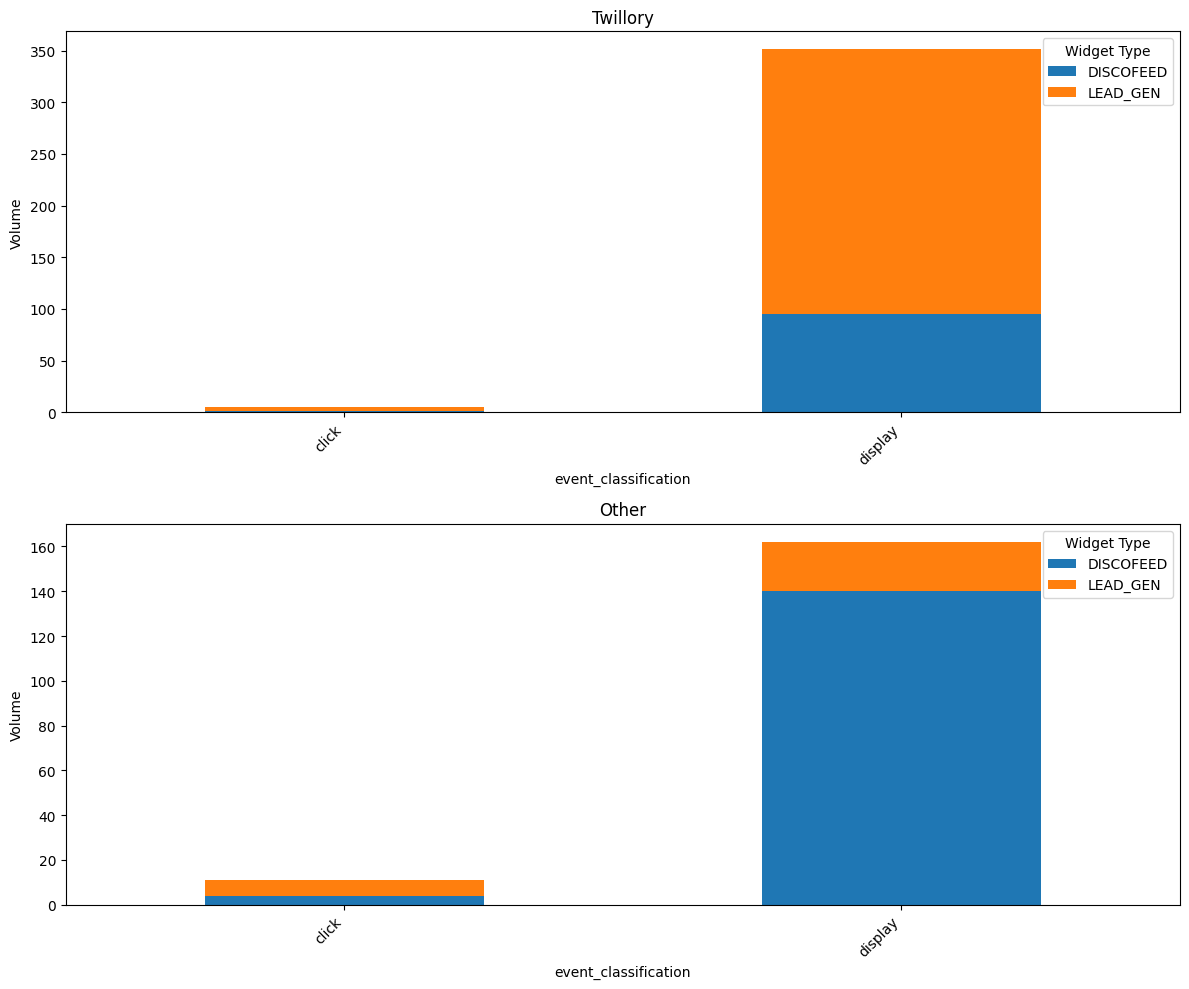

In [54]:
plot_column_analysis2(conv_df,'event_classification','volume')

In [71]:
zip_to_latlong = pd.read_csv('zip_lat_long.csv')
# zip_to_latlong.sample(5)

#convert zip to string
zip_to_latlong['ZIP'] = zip_to_latlong['ZIP'].astype(str)
conv_df = conv_df.merge(zip_to_latlong, how='left', left_on='shipping_address_zip_code', right_on='ZIP')

In [78]:
import folium
from folium.plugins import HeatMap

#filter for non null lat and long
map_df = conv_df[conv_df['LAT'].notnull() & conv_df['LNG'].notnull()]

# Now create a list of coordinate pairs and conversion counts
heat_data = [[row['LAT'], row['LNG'], row['order_id']] for index, row in map_df.iterrows()]

# Create the map centered around a specific location
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # You can change the location to your target area

# Add the heatmap to the map
HeatMap(heat_data).add_to(m)

# Save the map to an HTML file
m.save('heatmap.html')

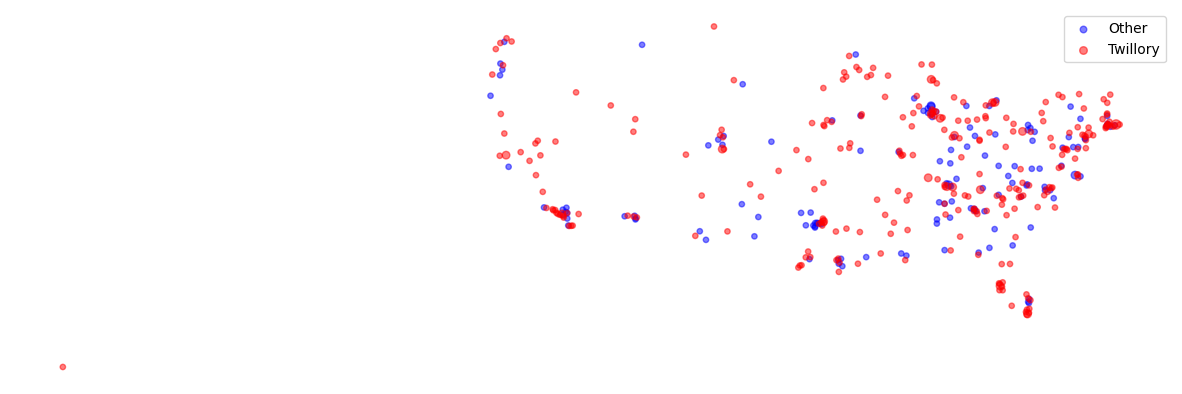

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Group by lat/long and publisher_name, then count the occurrences
location_counts = map_df.groupby(['LAT', 'LNG', 'publisher_name']).size().reset_index(name='counts')

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(location_counts, geometry=location_counts.apply(lambda row: Point(row['LNG'], row['LAT']), axis=1))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(15, 10))

# Dictionary to assign colors to each publisher_name
# You might need to adjust or expand this based on your actual publisher names
color_map = {
    'Twillory': 'red',
    'Other': 'blue'
    # Add more publishers and their colors as needed
}

# Loop through each publisher and plot their data points
for publisher, data in gdf.groupby('publisher_name'):
    color = color_map.get(publisher, 'gray')  # Default to 'gray' if publisher not in color_map
    data.plot(ax=ax, markersize=data['counts']*15, alpha=0.5, color=color, label=publisher)

# Add a legend to the plot
ax.legend()

# Remove x and y axis for cleaner look
ax.set_axis_off()

plt.show()